In [1]:
!apt-get -y install openjdk-8-jre-headless
!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic fonts-ipafont-mincho
  fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jre-headless
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 28.2 MB of archives.
After this operation, 104 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Fetched 28.2 MB in 4s (7,252 kB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u312-b07-0ubuntu1~18.04_amd64

In [2]:
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from pyspark.sql.functions import unix_timestamp, date_format, col, when
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Dataset Overview

In [ ]:
import pandas as pd
df = pd.read_csv('public.csv')
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15565701,Ferri,698,Spain,Female,39,9,161993.89,1,0,0,90212.38,0
1,15565706,Akobundu,612,Spain,Male,35,1,0.00,1,1,1,83256.26,1
2,15565796,Docherty,745,Germany,Male,48,10,96048.55,1,1,0,74510.65,0
3,15565806,Toosey,532,France,Male,38,9,0.00,2,0,0,30583.95,0
4,15565878,Bates,631,Spain,Male,29,3,0.00,2,1,1,197963.46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,15815628,Moysey,711,France,Female,37,8,113899.92,1,0,0,80215.20,0
7996,15815645,Akhtar,481,France,Male,37,8,152303.66,2,1,1,175082.20,0
7997,15815656,Hopkins,541,Germany,Female,39,9,100116.67,1,1,1,199808.10,1
7998,15815660,Mazzi,758,France,Female,34,1,154139.45,1,1,1,60728.89,0


# Use Pyspark to view dataset 

In [3]:
# These part is  for windows version, if you use ubuntu, remember to edit import pyspark part
# ----
"""import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()"""
# ----
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
conf = SparkConf().setAppName('Churn_Modelling').setMaster('local[6]')
sc = SparkContext(conf=conf)
sql_context = SQLContext(sc)
df = sql_context.read.csv('public.csv',header=True,inferSchema=True)
#spark = SparkSession.builder.appName("Churn_Modelling").getOrCreate()
#df = spark.read.csv('public.csv',header=True,inferSchema=True)
df.printSchema()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


root
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



# Visualize correlation

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']

df.describe(numeric_features).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Exited,8000,0.2055,0.40409177332650426,0,1
CreditScore,8000,650.56075,96.57993331887042,350,850
Age,8000,38.86575,10.453809698126834,18,92
Tenure,8000,5.013,2.8814699128408985,0,10
Balance,8000,76246.10825624973,62449.9722589656,0.0,250898.09
NumOfProducts,8000,1.53175,0.5807616533589768,1,4
EstimatedSalary,8000,99808.87008499997,57561.38062399992,11.58,199970.74
HasCrCard,8000,0.414,0.9103337785936287,-1,1
IsActiveMember,8000,0.028,0.9996704044907511,-1,1


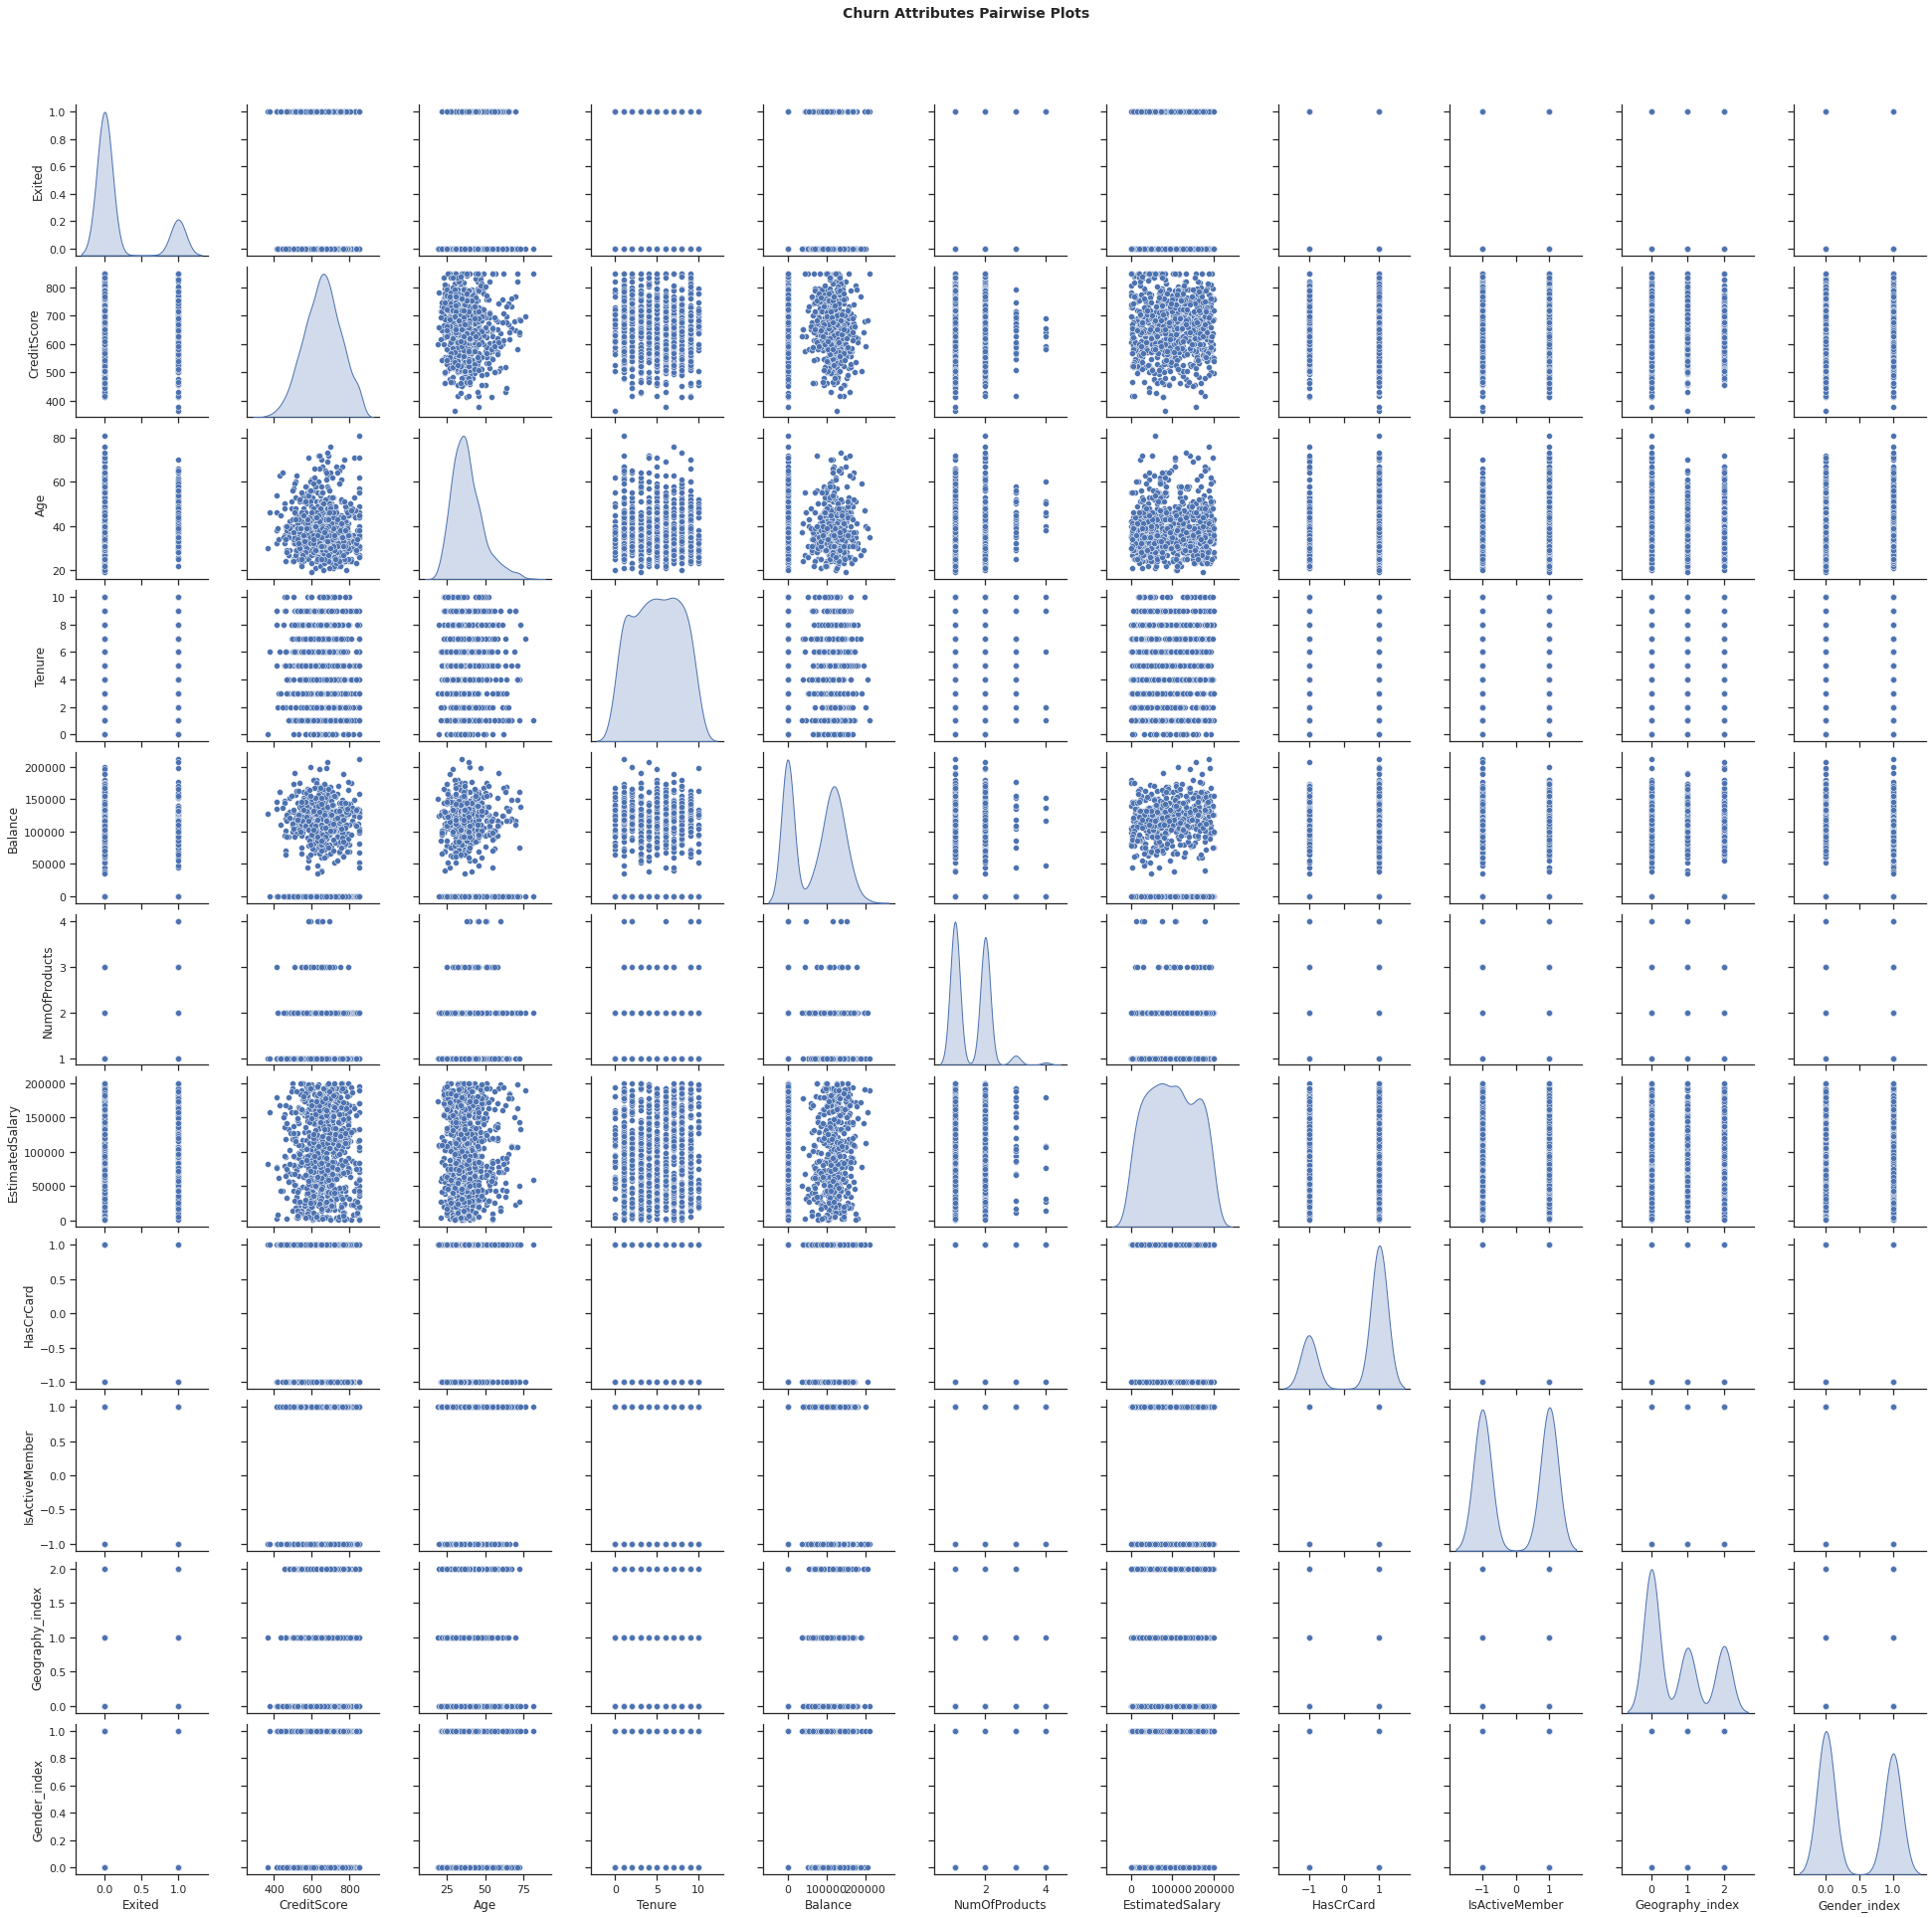

In [ ]:
sampled_data = df.select(numeric_features).sample(False, 0.10)
import seaborn as sns
sns.set(style="ticks")

g = sns.pairplot(sampled_data.toPandas(), diag_kind="kde")
fig = g.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Churn Attributes Pairwise Plots', fontsize=14, fontweight='bold');

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

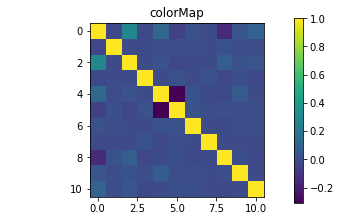

In [ ]:
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(cor_np)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

# Data Cleaning

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, StructType, StructField, IntegerType
# convert_gender = F.udf(lambda x: 1 if x == 'Male' else 0, IntegerType())
# df = df.withColumn('GenderBinary', convert_gender('Gender'))
# df.show()



continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df = df[['CustomerId']+['Exited'] + continuous_vars + cat_vars]

SI_Geography = StringIndexer(inputCol='Geography',outputCol='Geography_index')
SI_Gender = StringIndexer(inputCol='Gender',outputCol='Gender_index')
df = SI_Geography.fit(df).transform(df)
df = SI_Gender.fit(df).transform(df)

convert_gender = F.udf(lambda x: -1 if x == 0 else 1, IntegerType())
df = df.withColumn('HasCrCard', convert_gender('HasCrCard'))
df = df.withColumn('IsActiveMember', convert_gender('IsActiveMember'))

"""
distinct_values = df.select("Geography")\
                    .distinct()\
                    .rdd\
                    .flatMap(lambda x: x).collect()

for distinct_value in distinct_values:
    function = F.udf(lambda item: 
                   1 if item == distinct_value else 0, 
                   IntegerType())
    new_column_name = "Geography"+'_'+distinct_value
    df = df.withColumn(new_column_name, function(col("Geography")))



distinct_values = df.select("Gender")\
                    .distinct()\
                    .rdd\
                    .flatMap(lambda x: x).collect()

for distinct_value in distinct_values:
    function = F.udf(lambda item: 
                   1 if item == distinct_value else 0, 
                   IntegerType())
    new_column_name = "Gender"+'_'+distinct_value
    df = df.withColumn(new_column_name, function(col("Gender")))
"""

'\ndistinct_values = df.select("Geography")                    .distinct()                    .rdd                    .flatMap(lambda x: x).collect()\n\nfor distinct_value in distinct_values:\n    function = F.udf(lambda item: \n                   1 if item == distinct_value else 0, \n                   IntegerType())\n    new_column_name = "Geography"+\'_\'+distinct_value\n    df = df.withColumn(new_column_name, function(col("Geography")))\n\n\n\ndistinct_values = df.select("Gender")                    .distinct()                    .rdd                    .flatMap(lambda x: x).collect()\n\nfor distinct_value in distinct_values:\n    function = F.udf(lambda item: \n                   1 if item == distinct_value else 0, \n                   IntegerType())\n    new_column_name = "Gender"+\'_\'+distinct_value\n    df = df.withColumn(new_column_name, function(col("Gender")))\n'

In [5]:
df = df.drop('Geography', 'Gender')

# Scaling

In [ ]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterating over columns to be scaled
for i in ["CreditScore","Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
df.show(5)

After Scaling :
+------+-----------+---+------+---------+-------------+---------------+---------+--------------+---------------+------------+------------------+----------+-------------+--------------+--------------------+----------------------+
|Exited|CreditScore|Age|Tenure|  Balance|NumOfProducts|EstimatedSalary|HasCrCard|IsActiveMember|Geography_index|Gender_index|CreditScore_Scaled|Age_Scaled|Tenure_Scaled|Balance_Scaled|NumOfProducts_Scaled|EstimatedSalary_Scaled|
+------+-----------+---+------+---------+-------------+---------------+---------+--------------+---------------+------------+------------------+----------+-------------+--------------+--------------------+----------------------+
|     0|        698| 39|     9|161993.89|            1|       90212.38|       -1|            -1|            2.0|         1.0|             0.696|     0.284|          0.9|         0.646|                 0.0|                 0.451|
|     1|        612| 35|     1|      0.0|            1|       83256.

In [ ]:
df = df.drop("CreditScore","Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary")

In [ ]:

df.show()


+------+---------+--------------+---------------+------------+------------------+----------+-------------+--------------+--------------------+----------------------+
|Exited|HasCrCard|IsActiveMember|Geography_index|Gender_index|CreditScore_Scaled|Age_Scaled|Tenure_Scaled|Balance_Scaled|NumOfProducts_Scaled|EstimatedSalary_Scaled|
+------+---------+--------------+---------------+------------+------------------+----------+-------------+--------------+--------------------+----------------------+
|     0|       -1|            -1|            2.0|         1.0|             0.696|     0.284|          0.9|         0.646|                 0.0|                 0.451|
|     1|        1|             1|            2.0|         0.0|             0.524|      0.23|          0.1|           0.0|                 0.0|                 0.416|
|     0|        1|            -1|            1.0|         0.0|              0.79|     0.405|          1.0|         0.383|                 0.0|                 0.373|
|   

In [ ]:

df.printSchema()



root
 |-- Exited: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- Geography_index: double (nullable = false)
 |-- Gender_index: double (nullable = false)
 |-- CreditScore_Scaled: double (nullable = true)
 |-- Age_Scaled: double (nullable = true)
 |-- Tenure_Scaled: double (nullable = true)
 |-- Balance_Scaled: double (nullable = true)
 |-- NumOfProducts_Scaled: double (nullable = true)
 |-- EstimatedSalary_Scaled: double (nullable = true)



# Modeling

In [6]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler

#f1 - 0.589
#assembler=VectorAssembler(inputCols=['HasCrCard','IsActiveMember','Geography_index','Gender_index','CreditScore_Scaled','Age_Scaled','Tenure_Scaled','Balance_Scaled', 'NumOfProducts_Scaled', 'EstimatedSalary_Scaled'],outputCol='features')
#f1 - 0.576
#assembler=VectorAssembler(inputCols=['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','HasCrCard','IsActiveMember','Geography_index','Gender_index'],outputCol='features')
#f1 - 0.6
assembler=VectorAssembler(inputCols=['HasCrCard','IsActiveMember','Geography_index','Gender_index','CreditScore','Age','Tenure','Balance', 'NumOfProducts', 'EstimatedSalary'],outputCol='features',handleInvalid = 'skip')
standardscaler = StandardScaler(inputCol="features", outputCol="Final_features", withMean=True, withStd=True)
output_data=assembler.transform(df)

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
balancingRatio = output_data.filter(col('Exited') == 1).count() / output_data.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())
weightedDataset = output_data.withColumn('classWeightCol', calculateWeights('Exited'))

In [ ]:
weightedDataset.show()

+----------+------+-----------+---+------+---------+-------------+---------------+---------+--------------+---------------+------------+--------------------+--------------+
|CustomerId|Exited|CreditScore|Age|Tenure|  Balance|NumOfProducts|EstimatedSalary|HasCrCard|IsActiveMember|Geography_index|Gender_index|            features|classWeightCol|
+----------+------+-----------+---+------+---------+-------------+---------------+---------+--------------+---------------+------------+--------------------+--------------+
|  15565701|     0|        698| 39|     9|161993.89|            1|       90212.38|       -1|            -1|            2.0|         1.0|[-1.0,-1.0,2.0,1....|        0.2055|
|  15565706|     1|        612| 35|     1|      0.0|            1|       83256.26|        1|             1|            2.0|         0.0|[1.0,1.0,2.0,0.0,...|        0.7945|
|  15565796|     0|        745| 48|    10| 96048.55|            1|       74510.65|        1|            -1|            1.0|         0.0

In [8]:
from pyspark.ml.tuning import CrossValidator

class F1BinaryEvaluator():

    def __init__(self, predCol="prediction", labelCol="Exited", metricLabel=1.0):
        self.labelCol = labelCol
        self.predCol = predCol
        self.metricLabel = metricLabel

    def isLargerBetter(self):
        return True

    def evaluate(self, dataframe):
        tp = dataframe.filter(self.labelCol + ' = ' + str(self.metricLabel) + ' and ' + self.predCol + ' = ' + str(self.metricLabel)).count()
        fp = dataframe.filter(self.labelCol + ' != ' + str(self.metricLabel) + ' and ' + self.predCol + ' = ' + str(self.metricLabel)).count()
        fn = dataframe.filter(self.labelCol + ' = ' + str(self.metricLabel) + ' and ' + self.predCol + ' != ' + str(self.metricLabel)).count()
        return tp / (tp + (.5 * (fn +fp)))



def fit_model(model, train, validation, standardscaler, f1_evaluator, paramGrid = None):
    # Model fitting with selected model and paramgric(optional)
    # Input: model, paramgrid
    # Output: fitted model, prediction on validation set
    pipeline = Pipeline(stages=[standardscaler, model])
    #eval = MulticlassClassificationEvaluator(labelCol="Exited", metricName='fMeasureByLabel', metricLabel=1)
    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Exited", metricName='fMeasureByLabel', metricLabel=1), #f1_evaluator,
                          numFolds=5, parallelism=10)
        
        fitmodel = crossval.fit(train)
        results = fitmodel.bestModel.transform(validation)
        print("  numTrees:", fitmodel.bestModel.stages[-1]._java_obj.parent().getNumTrees())
        print("  maxDepth:", fitmodel.bestModel.stages[-1]._java_obj.parent().getMaxDepth())
        print("  maxBins:", fitmodel.bestModel.stages[-1]._java_obj.parent().getMaxBins())
        return fitmodel, fitmodel.bestModel, results#, eval(fitmodel.bestModel.transform(validation))
    else:
        fitmodel = pipeline.fit(train)
        results = fitmodel.transform(validation)
        return fitmodel, results

In [9]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#0.48
"""gb = LogisticRegression(featuresCol="Final_features", labelCol = 'Exited')
gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.regParam, [0.01, 0.1, 0.3])
             .addGrid(gb.maxIter, [5, 7, 10, 15, 20, 30])
             .build())"""
#0.789
# numTrees: 20
# maxDepth: 10
# maxBins: 20
gb = RandomForestClassifier(featuresCol="Final_features", labelCol = 'Exited')
gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.numTrees, [20])
             .addGrid(gb.maxDepth, [10])
             .addGrid(gb.maxBins, [20])
             .build())
"""gb = GBTClassifier(featuresCol="Final_features", labelCol="Exited")
gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5, 7, 10, 15, 20, 30])
             .addGrid(gb.maxBins, [10, 20, 30, 40])
             .addGrid(gb.maxIter, [5, 7, 10, 15, 20, 30])
             .build())"""
(train, test) = weightedDataset.randomSplit([0.8, 0.2], seed=42)
f1_evaluator = F1BinaryEvaluator()
#0.63
cvModel, lrweightedmodel, lrweightedresults = fit_model(gb.setWeightCol('classWeightCol'), weightedDataset, weightedDataset, standardscaler ,f1_evaluator,  gbparamGrid)

  numTrees: 20
  maxDepth: 10
  maxBins: 20


# Public Evaluation Part

In [10]:
from sklearn.metrics import confusion_matrix
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="Exited")
acc = evaluator.evaluate(lrweightedresults)
 
print("Prediction Accuracy: ", acc)
 
y_pred=lrweightedresults.select("prediction").collect()
y_orig=lrweightedresults.select("Exited").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.9016131172001552
Confusion Matrix:
[[5831  525]
 [ 282 1362]]


In [11]:
from sklearn import metrics
import numpy as np
data_array =  np.array(lrweightedresults.select('prediction').collect())
gt =  np.array(lrweightedresults.select('Exited').collect())

metrics.f1_score(data_array,gt)  

0.7714528462192015